In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from sim import *
from read_ramses import *


### runtime

Text(0, 0.5, '$a_{\\rm exp}$')

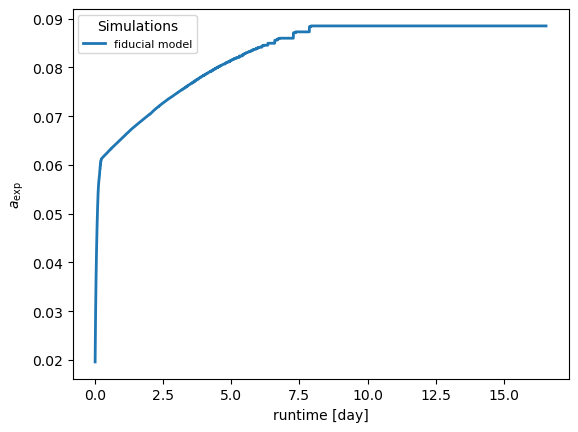

In [5]:
list_of_sim_round = [9]
list_of_sim_name = ["fiducial"]
project = False
time_min = 5 * const.day
a_exp_max = 0.1

i = 0
table = []
for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name
    for sim_name in list_of_sim_name_round:
        sim_latex = sim_name_to_latex[sim_name]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        time, a_exp, num_oct_level, num_oct_total = read_logfile()
        plt.plot(time[:len(a_exp)] / const.day, a_exp[:len(time)], lw=2, label=sim_latex, color='C%d' % i)
        if project == True:
            linear = lambda x, a, b: a * x + b
            cond = time > time_min
            popt, _ = curve_fit(linear, time[cond], a_exp[cond])
            time_max = (a_exp_max - popt[1]) / popt[0]
            time_extrema = np.array([time_min, time_max])
            plt.plot(time_extrema / const.day, linear(time_extrema, *popt), linestyle='--', color='C%d' % i)
            table.append([sim_name, "%.3g" % ((time_max - time[-1]) / const.day), "%.3g" % (time_max / const.day)])
        
        i += 1

plt.legend(ncol=len(list_of_sim_round), fontsize=8, title='Simulations')
if project == True: print(tabulate(table, headers=['Simulation', 'Runtime Left (day)', 'Runtime Tot (day)']))

plt.xlabel("runtime [day]")
plt.ylabel(r"$a_{\rm exp}$")

#save_fig("runtime-r5")


### resolution

Text(0, 0.5, '$N_{\\rm oct}$ [million]')

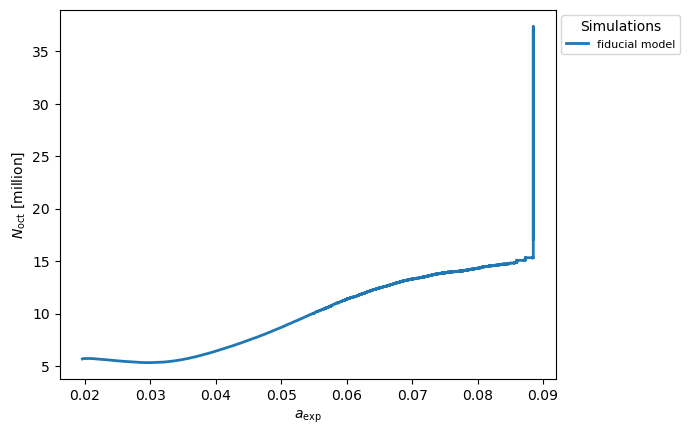

In [19]:
list_of_sim_round = [9]
list_of_sim_name = ['fiducial']

i = 0
for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name
    for sim_name in list_of_sim_name_round:
        sim_latex = sim_name_to_latex[sim_name]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        time, a_exp, num_oct_level, num_oct_tot = read_logfile()
        plt.plot(a_exp[:len(num_oct_tot)], num_oct_tot / 1e6, lw=2, label=sim_latex, color='C%d' % i)
        i += 1
    
plt.legend(bbox_to_anchor=(1., 1.), loc="upper left", fontsize=8, title='Simulations')

plt.xlabel(r"$a_{\rm exp}$")
plt.ylabel(r'$N_{\rm oct}$ [million]')

#save_fig("numoct-r8")


Text(0.5, 1.0, 'fiducial model')

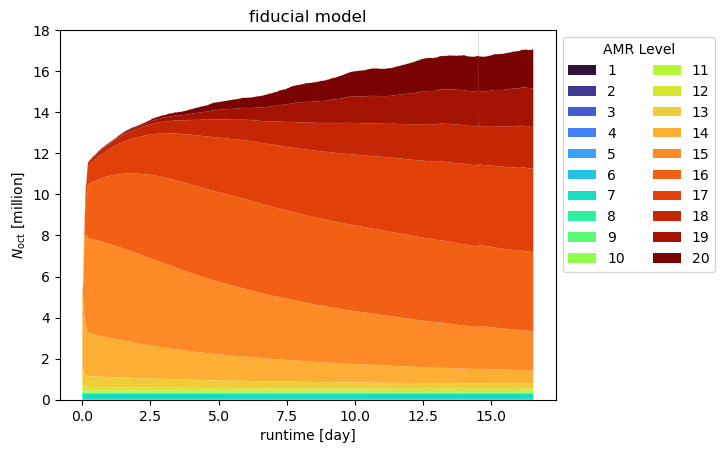

In [35]:
sim_round = 9
sim_name = "fiducial"
sim_latex = sim_name_to_latex[sim_name]

move_to_sim_dir(sim_round, sim_name, do_print=False)
time, a_exp, num_oct_level, num_oct_tot = read_logfile()

amr_level_max_coarse = num_oct_level.shape[0]
colors = mpl.cm.turbo(np.linspace(0, 1, amr_level_max_coarse))

plt.ylim(0, 18)

plt.stackplot(time[:len(num_oct_tot)] / const.day, *num_oct_level / 1e6, colors=colors, labels=range(1, amr_level_max_coarse+1))
plt.legend(bbox_to_anchor=(1., 1.), loc="upper left", ncols=2, title='AMR Level')
plt.xlabel('runtime [day]')
plt.ylabel(r'$N_{\rm oct}$ [million]')
plt.title(sim_latex)

#save_fig("numoct-level-r5-dxmin")


### task breakdown

Text(0, 0.5, 'percent time [%]')

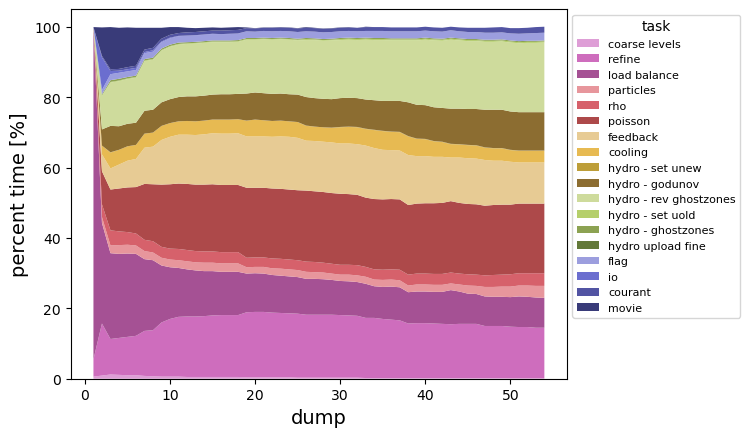

In [26]:
sim_round = 9
sim_name = "fiducial"
sim_latex = sim_name_to_latex[sim_name]

move_to_sim_dir(sim_round, sim_name, do_print=False)

timing = read_timer()

list_of_timing_category = list(timing.keys())[:-2]
colors = mpl.cm.tab20b_r([0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

plt.stackplot(timing['dump'], *[timing[category]['percent'] for category in list_of_timing_category], labels=list_of_timing_category, colors=colors)
plt.legend(bbox_to_anchor=(1., 1.), loc="upper left", fontsize=8, title='task')
plt.xlabel('dump', fontsize=14)
plt.ylabel('percent time [%]', fontsize=14)

# save_fig("timing-r4-gas", subdir='meta')


In [40]:
3*np.pi / const.Myr**2 / (32*const.G) * const.X_cosmo / const.m_p

2016.1926585304004

### fit cubic to biggest halo coord

In [210]:
#sim_round = 1
#sim_name = "alpha_eps0p1"

#move_to_sim_dir(sim_round, sim_name, do_print=False)

os.chdir("/home/rt3504/scratch/dekel_midres/alpha_eps0p1_2")


In [211]:
N = 10

list_of_dump = get_list_of_dump()[3:]
a_exp = np.zeros((list_of_dump.size))

# (strategy, dump, place, coord)
coord_big_halo = np.zeros((3, list_of_dump.size, N, 3))
coord_big_clump = np.zeros((5, list_of_dump.size, N, 3))

for i, dump in enumerate(list_of_dump):
    
    info = get_info(dump)
    a_exp[i] = info.a_exp
    
    halo_cat = get_halo_cat(dump)
    coord_big_halo[0, i] = halo_cat.coord[:, np.argsort(halo_cat.ncell)[-N:][::-1]].T
    coord_big_halo[1, i] = halo_cat.coord[:, np.argsort(halo_cat.density_max)[-N:][::-1]].T
    coord_big_halo[2, i] = halo_cat.coord[:, np.argsort(halo_cat.mass)[-N:][::-1]].T
    
    #clump_cat = get_clump_cat(dump)
    #coord_big_clump[0, i] = clump_cat.coord[:, np.argsort(clump_cat.ncell)[-N:][::-1]].T
    #coord_big_clump[1, i] = clump_cat.coord[:, np.argsort(clump_cat.density_border)[-N:][::-1]].T
    #coord_big_clump[2, i] = clump_cat.coord[:, np.argsort(clump_cat.density_max)[-N:][::-1]].T
    #coord_big_clump[3, i] = clump_cat.coord[:, np.argsort(clump_cat.density_avg)[-N:][::-1]].T
    #coord_big_clump[4, i] = clump_cat.coord[:, np.argsort(clump_cat.mass)[-N:][::-1]].T
    
coord_to_phys_unit = lambda coord: (coord - 0.5) * info.length_unit / const.kpc


Text(0.5, 0, '$a$')

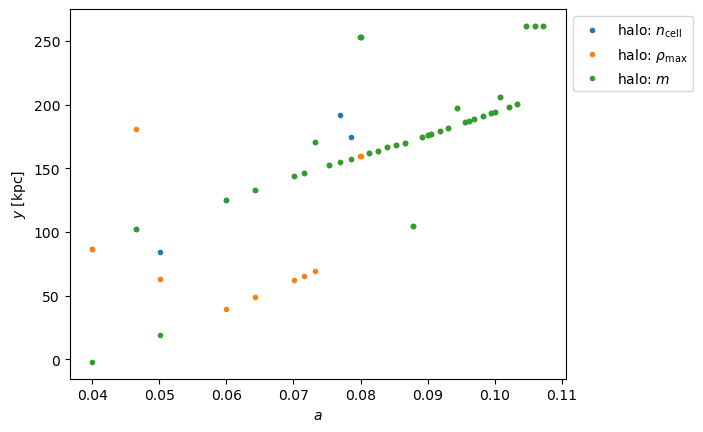

In [216]:
slice = Y

#plt.plot(a_exp, coord_to_phys_unit(coord_big_clump[0, :, 0, slice]), '.', label=r'clump: $n_{\rm cell}$')
#plt.plot(a_exp, coord_to_phys_unit(coord_big_clump[1, :, 0, slice]), '.', label=r'clump: $\rho_{\rm border}$')
#plt.plot(a_exp, coord_to_phys_unit(coord_big_clump[2, :, 0, slice]), '.', label=r'clump: $\rho_{\rm max}$')
#plt.plot(a_exp, coord_to_phys_unit(coord_big_clump[3, :, 0, slice]), '.', label=r'clump: $\rho_{\rm avg}$')
#plt.plot(a_exp, coord_to_phys_unit(coord_big_clump[4, :, 0, slice]), '.', label=r'clump: $m$')
plt.plot(a_exp, coord_to_phys_unit(coord_big_halo[0, :, 0, slice]), '.', label=r'halo: $n_{\rm cell}$')
plt.plot(a_exp, coord_to_phys_unit(coord_big_halo[1, :, 0, slice]), '.', label=r'halo: $\rho_{\rm max}$')
plt.plot(a_exp, coord_to_phys_unit(coord_big_halo[2, :, 0, slice]), '.', label=r'halo: $m$')

plt.legend(bbox_to_anchor=(1., 1.), loc="upper left")

plt.ylabel([r"$x$ [kpc]", r"$y$ [kpc]", r"$z$ [kpc]"][slice])
plt.xlabel(r"$a$")

#save_fig("all-points-z")


Text(0.5, 0, '$a$')

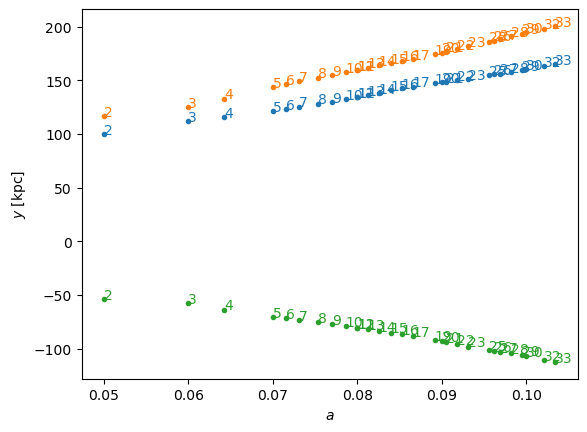

In [276]:
place = np.zeros((a_exp.size), dtype=int)
place[36] = -1
place[35] = -1
place[34] = -1
place[31] = -1
place[24] = -1
place[18] = -1
place[12] = 1
place[11] = 1
place[7] = 1
place[2] = 1
place[1] = -1
place[0] = -1

a_exp_frame = []
coord_frame = [[], [], []]

for i in range(a_exp.size):
    
    if place[i] != -1:
        a_exp_frame.append(a_exp[i])
        for coord_idx in [X, Y, Z]:
            coord_frame[coord_idx].append(coord_big_halo[2, i, place[i], coord_idx])
            plt.plot(a_exp[i], coord_to_phys_unit(coord_frame[coord_idx][-1]), marker='.', color='C%d' % coord_idx)
            plt.annotate("%d" % i, (a_exp[i], coord_to_phys_unit(coord_frame[coord_idx][-1])), color='C%d' % coord_idx)

a_exp_frame = np.array(a_exp_frame)
coord_frame = np.array(coord_frame)
            
plt.ylabel([r"$x$ [kpc]", r"$y$ [kpc]", r"$z$ [kpc]"][slice])
plt.xlabel(r"$a$")


[0.50685686, -0.085267235, 1.9921783, -7.7235762]
[0.5065317, -0.049495054, 1.6965165, -5.8186623]
[0.49536868, 0.093198848, -1.6449332, 4.735689]
Saved figure as 'cubic-fit-110320231648.png'


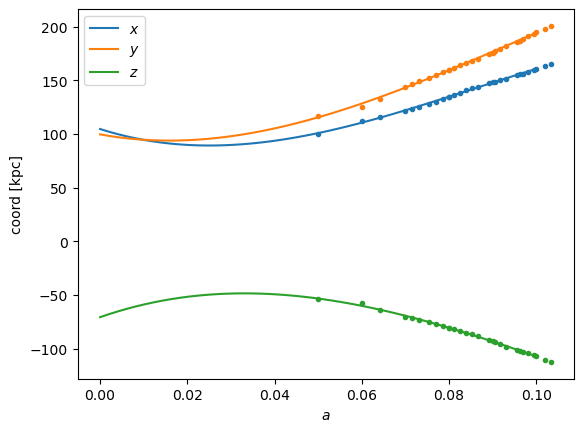

In [283]:
cubic = lambda x, a, b, c, d: a + b*x + c*x**2 + d*x**3

poptx, _ = curve_fit(cubic, a_exp_frame, coord_frame[X])
popty, _ = curve_fit(cubic, a_exp_frame, coord_frame[Y])
poptz, _ = curve_fit(cubic, a_exp_frame, coord_frame[Z])

a_exp_space = np.linspace(0, 0.1)

plt.plot(a_exp_frame, coord_to_phys_unit(coord_frame[X]), '.', color='C0')
plt.plot(a_exp_frame, coord_to_phys_unit(coord_frame[Y]), '.', color='C1')
plt.plot(a_exp_frame, coord_to_phys_unit(coord_frame[Z]), '.', color='C2')

plt.plot(a_exp_space, coord_to_phys_unit(cubic(a_exp_space, *poptx)), label=r'$x$', color='C0')
plt.plot(a_exp_space, coord_to_phys_unit(cubic(a_exp_space, *popty)), label=r'$y$', color='C1')
plt.plot(a_exp_space, coord_to_phys_unit(cubic(a_exp_space, *poptz)), label=r'$z$', color='C2')

plt.legend()

plt.ylabel("coord [kpc]")
plt.xlabel(r"$a$")

print("[%.8g, %.8g, %.8g, %.8g]" % tuple(poptx))
print("[%.8g, %.8g, %.8g, %.8g]" % tuple(popty))
print("[%.8g, %.8g, %.8g, %.8g]" % tuple(poptz))

save_fig("cubic-fit")


In [285]:
sim_width_comoving = 200 * const.Mpc
frame_width_physical = 20 * const.kpc
a_exp_max = 0.1
frame_width_px = 1080

deltax_frame = frame_width_physical / (a_exp_max * sim_width_comoving)
levelmax_frame = np.ceil(np.log2(a_exp_max * sim_width_comoving / (frame_width_physical / frame_width_px)))

print("deltax_frame: %.3g" % deltax_frame)
print("levelmax_frame: %d" % levelmax_frame)


deltax_frame: 0.001
levelmax_frame: 21
